In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import models
import numpy as np
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import os
import json
from konlpy.tag import Okt
import pymysql.cursors
import pandas as pd
import re

In [12]:
conn = pymysql.connect(host='localhost',
                       user='lyunj',
                       password='Dldbswo77@',
                       db='coupang_review',  # coupang_review 스키마 생성 필요
                       charset='utf8',
                       cursorclass=pymysql.cursors.DictCursor)

try:
    with conn.cursor() as curs:
        sql = 'select rating,review_content, review_len from csv_save where (rating =1 or rating=5) and review_len <> 0'
        curs.execute(sql)
        result = curs.fetchall()
        df = pd.DataFrame(result)
finally:
    conn.close()

In [13]:
okt = Okt()

In [14]:
def tokenize(review):
    return ['/'.join(t) for t in okt.pos(review, norm=True, stem=True)]

In [15]:
reviews = []
print(df.loc[1:5])
for i in df.index:
    if i % 100 == 0:
        print('진행개수 : ', i)
    row = df._get_value(i, 'review_content')
    row = re.sub('\n', '', row)
    row = re.sub('\u200b', '', row)
    row = re.sub('\xa0', '', row)
    row = re.sub('([a-zA-Z])', '', row)
    row = re.sub('[ㄱ-ㅎㅏ-ㅣ]+', '', row)
    row = re.sub(
        '[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', row)
    reviews.append([tokenize(row), str(df._get_value(i, 'rating')),str(df._get_value(i,'review_len'))])

with open('review_token.json', 'w', encoding='utf-8') as make_file:
    json.dump(reviews, make_file, ensure_ascii=False, indent='\t')

   rating                                     review_content  review_len
1       1  날마다 자전거를 타기에 요즘 햇볕에 노출된 팔부분이 많이 탓기에 토시를 구입했는데 ...         234
2       1  탄력이 없어서 죽죽 내려옵니다.\n\n가격은 비싸고 k2 이름값을 못하네요.\n길이...         201
3       1  다 좋은데 질이 참 ...\n플라스틱 모서리에 살짝 걸려서 올하나가 풀리더만 사진처...         100
4       1             마감 처리가 잘 안되어 한번 세탁하니 올이 심하게 풀려서 못쓰겠습니다          38
5       1  1회착용 보푸라기일어남 \n원플원인데 \n1회착용 폐기 ㅋㅋㅋ\n만원이니까\n한번쓰...          87
진행개수 :  0
진행개수 :  100
진행개수 :  200
진행개수 :  300
진행개수 :  400
진행개수 :  500
진행개수 :  600
진행개수 :  700
진행개수 :  800
진행개수 :  900
진행개수 :  1000
진행개수 :  1100
진행개수 :  1200
진행개수 :  1300
진행개수 :  1400
진행개수 :  1500
진행개수 :  1600
진행개수 :  1700
진행개수 :  1800
진행개수 :  1900
진행개수 :  2000
진행개수 :  2100
진행개수 :  2200
진행개수 :  2300
진행개수 :  2400
진행개수 :  2500
진행개수 :  2600
진행개수 :  2700
진행개수 :  2800
진행개수 :  2900
진행개수 :  3000
진행개수 :  3100
진행개수 :  3200
진행개수 :  3300
진행개수 :  3400
진행개수 :  3500
진행개수 :  3600
진행개수 :  3700
진행개수 :  3800
진행개수 :  3900
진행개수 :  4000
진행개수 :  4100
진행개수 :  4200
진행개수 :  4300
진행

In [16]:
import nltk

with open('review_token.json', encoding='utf-8') as f:
    review_token = json.load(f)

tokens = [t for d in review_token for t in d[0] if ((
    t.split('/')[1] == 'Noun') or (t.split('/')[1] == 'Adjective'))]

text = nltk.Text(tokens, name='NMSC')

print(len(set(text.tokens)))

35951


In [17]:
tokens_1 = [t for d in review_token for t in d[0] if (((
    t.split('/')[1] == 'Noun') or
    (t.split('/')[1] == 'Adjective')) and d[1] == '1')]

text_1 = nltk.Text(tokens_1, name='NMSC')

rating_1 = text_1.vocab().most_common(1000)

tokens_5 = [t for d in review_token for t in d[0] if (((
    t.split('/')[1] == 'Noun') or
    (t.split('/')[1] == 'Adjective')) and d[1] == '5')]
text_5 = nltk.Text(tokens_5, name='NMSC')

rating_5 = text_5.vocab().most_common(1000)

rating_1_word = [x[0] for x in rating_1]
rating_5_word = [x[0] for x in rating_5]

common_word = [x for x in rating_1_word if x in rating_5_word]

rating_1_word_not_common = [x for x in rating_1_word if x not in common_word]
rating_5_word_not_common = [x for x in rating_5_word if x not in common_word]

# tokens_1_word = [x for x in tokens_1 if x not in common_word]
# tokens_5_word = [x for x in tokens_5 if x not in common_word]

In [18]:
print(len(common_word))
print(len(rating_1_word_not_common))
print(len(rating_5_word_not_common))

698
302
302


In [19]:
text_count = text.vocab()
text_count

FreqDist({'좋다/Adjective': 53003, '있다/Adjective': 38706, '같다/Adjective': 27207, '구매/Noun': 22808, '사용/Noun': 20908, '없다/Adjective': 19700, '것/Noun': 19686, '제품/Noun': 18359, '때/Noun': 16949, '가격/Noun': 16122, ...})

In [20]:
# common_token = [int(text_count[x]) for x in common_word]
# rating_1_token = [int(text_count[x]) for x in rating_1_word_not_common]
# rating_5_token = [int(text_count[x]) for x in rating_5_word_not_common]

In [21]:
# common_max = max(common_token)
# common_min = min(common_token)
# rating_1_max = max(rating_1_token)
# rating_1_min = min(rating_1_token)
# rating_5_max = max(rating_5_token)
# rating_5_min = min(rating_5_token)
# print(common_max)
# print(common_min)
# print(rating_1_max)
# print(rating_1_min)
# print(rating_5_max)
# print(rating_5_min)

In [22]:
common_word_sort = [x for x in text_count if x in common_word]
rating_1_word_sort = [x for x in text_count if x in rating_1_word_not_common]
rating_5_word_sort = [x for x in text_count if x in rating_5_word_not_common]

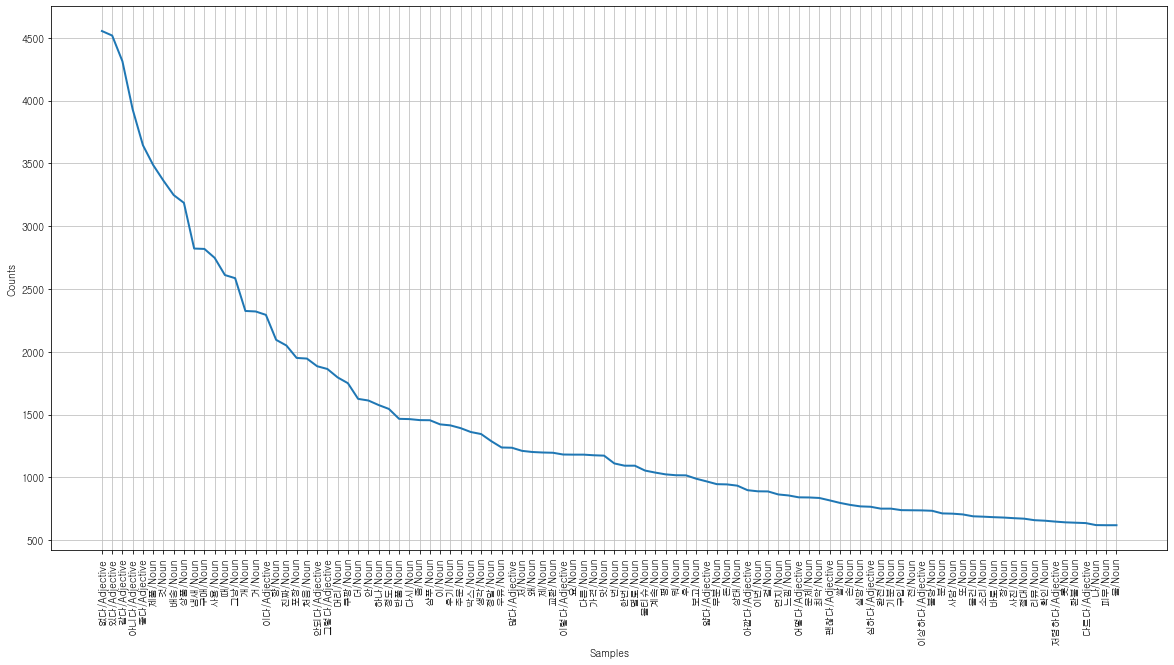

In [23]:
font_fname = 'c:/windows/fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)
plt.figure(figsize=(20, 10))
nltk.Text(tokens_1).plot(100)

In [24]:
com_ma = 0
com_mi = 1000000000
for f in common_word_sort[0:690]:
    for doc,_,_ in review_token:
        co = doc.count(f)
        if co > com_ma:
            com_ma = co
        if co < com_mi:
            com_mi = co

one_ma = 0
one_mi = 1000000000
for f in rating_1_word_sort[0:290]:
    for doc,_,_ in review_token:
        co = doc.count(f)
        if co > one_ma:
            one_ma = co
        if co < one_mi:
            one_mi = co

five_ma = 0
five_mi = 1000000000
for f in rating_5_word_sort[0:290]:
    for doc,_,_ in review_token:
        co = doc.count(f)
        if co > five_ma:
            five_ma = co
        if co < five_mi:
            five_mi = co

In [25]:
def norm_common(x):
    return (x - com_mi) / (com_ma - com_mi)
def norm_rating_1(x):
    return (x - one_mi) / (one_ma - one_mi)
def norm_rating_5(x):
    return (x - five_mi) / (five_ma - five_mi)

In [26]:
selected_words = [f for f in common_word_sort[0:690]] + [f for f in rating_1_word_sort[0:290]] + [f for f in rating_5_word_sort[0:290]]

In [27]:
# selected_words = [f[0] for f in text.vocab().most_common(1250)]

In [28]:
def term_frequency(doc,length):
    result = []
    count = 0
    for word in selected_words:
        if(count < 690):
            result.append(norm_common(doc.count(word)))
        if(690 <= count < 980):
            result.append(norm_rating_1(doc.count(word)))
        if(980 <= count < 1270):
            result.append(norm_rating_5(doc.count(word)))
        count += 1
    return result
#     return [doc.count(word) for word in selected_words]

X = [term_frequency(d,length) for d, _,length in review_token]
y = ['1' if d == '1' else '0' for _, d,_ in review_token]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=1004)

x_train = np.asarray(X_train).astype('float32')
x_test = np.asarray(X_test).astype('float32')

y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(1270,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

model.fit(x_train, y_train, epochs=10, batch_size=8)
results = model.evaluate(x_test, y_test)
print(results)
model.save('../saved_model/second_model')

In [30]:
selected_words[0]

'좋다/Adjective'

In [31]:
norm_common(review_token[0][0].count('좋다/Adjective'))

0.0

In [32]:
def predict_pos_neg(review):
    token = tokenize(review)
    tf = term_frequency(token,0)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
#         print("[{}]는 {:.2f}% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^\n".format(review, score * 100))
        return (1 - score) * 100
    else:
#         print("[{}]는 {:.2f}% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^;\n".format(review, (1 - score) * 100))
        return (1 - score) * 100

In [33]:
predict_pos_neg("""첫날 사진입니다.. 많이 실망스럽네요
저번에 시켜먹을땐 이거보단 덜했는데 이번엔 영 아니네요
베스트 후기 보면 초록빛 바나나도 주던데 전 그게 차라리 낫다고 생각합니다. 
바나나 만져보면 9개중에 5개의 끝부분이 말랑말랑하고
검게 시들었습니다.. 칼로 도려내야겠네요 
이게 첫날인데 몇일 지나면 절반은 못먹고 도려낼듯

+ 확인해보니 5개가 아니고 6개가 말랑말랑하네요ㅋ""")

3.3927559852600098

In [34]:
# conn = pymysql.connect(host='localhost',
#                        user='lyunj',
#                        password='Dldbswo77@',
#                        db='coupang_review',  # coupang_review 스키마 생성 필요
#                        charset='utf8',
#                        cursorclass=pymysql.cursors.DictCursor)

# try:
#     with conn.cursor() as curs:
#         sql = """select a.*,b.review_content
# from review_analyzing_data a left outer join review_content b on (
# a.product_review_index = b.product_review_index and
# a.product_index = b.product_index and
# a.category_index = b.category_index
# );"""
#         curs.execute(sql)
#         result = curs.fetchall()
#         df = pd.DataFrame(result)
# finally:
#     conn.close()

In [35]:
# for i in range(151321):
#     review_score = predict_pos_neg(df['review_content'][i])
#     conn = pymysql.connect(host='localhost',
#                        user='lyunj',
#                        password='Dldbswo77@',
#                        db='coupang_review',  # coupang_review 스키마 생성 필요
#                        charset='utf8',
#                        cursorclass=pymysql.cursors.DictCursor)
#     try:
#         with conn.cursor() as curs:
#             sql = f"update review_analyzing_data set review_score = {review_score} where product_review_index = {df['product_review_index'][i]} and product_index = {df['product_index'][i]} and category_index = {df['category_index'][i]}"
#             curs.execute(sql)
#             conn.commit()
#     finally:
#         conn.close()
#     if i % 1000 == 0:
#         print(i)